In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.ppm = PyramidPooling(
            16, [16, 6, 3, 2, 1], 16, 16
        )
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv = nn.Conv2d(31, 3, 3, stride = 1)
        self.flatten = nn.Flatten()     
        self.sigmoid = nn.Sigmoid()
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.ppm(x)
        
        #全結合層
        x = self.flatten(self.global_avg(self.sigmoid(self.conv(x))))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─PyramidPooling: 1-3                    [64, 31, 16, 16]          --
│    └─AdaptiveAvgPool2d: 2-5            [64, 16, 16, 16]          --
│    └─conv2DBatchNormRelu: 2-6          [64, 3, 16, 16]           --
│    │    └─Conv2d: 3-1                  [64, 3, 16, 16]           48
│    │    └─BatchNorm2d: 3-2             [64, 3, 16, 16]           6
│    │    └─ReLU: 3-3                    [64, 3, 16, 16]           --
│    │    └─Dro

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=200
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 1.0984 Acc: 0.3110
Epoch 2/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 1.0706 Acc: 0.4224


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 1.0739 Acc: 0.4086
Epoch 3/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 1.0342 Acc: 0.4935


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 1.0572 Acc: 0.3986
Epoch 4/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 1.0073 Acc: 0.5245


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.9784 Acc: 0.5871
Epoch 5/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.9926 Acc: 0.5536


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.9558 Acc: 0.6052
Epoch 6/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.9839 Acc: 0.5576


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.9825 Acc: 0.5105
Epoch 7/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.9827 Acc: 0.5495


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.04it/s]


val Loss: 0.9639 Acc: 0.5933
Epoch 8/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.9613 Acc: 0.5956


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.02it/s]


val Loss: 0.9125 Acc: 0.6633
Epoch 9/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it]


train Loss: 0.9581 Acc: 0.5886


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.03s/it]


val Loss: 0.9221 Acc: 0.5976
Epoch 10/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


train Loss: 0.9626 Acc: 0.5826


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.18it/s]


val Loss: 0.9358 Acc: 0.6024
Epoch 11/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.9559 Acc: 0.5796


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.9383 Acc: 0.5600
Epoch 12/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.9403 Acc: 0.6056


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.8957 Acc: 0.6281
Epoch 13/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.9342 Acc: 0.5996


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.9536 Acc: 0.5657
Epoch 14/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.9316 Acc: 0.6026


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.9130 Acc: 0.6424
Epoch 15/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.9305 Acc: 0.6066


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8737 Acc: 0.6881
Epoch 16/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.9198 Acc: 0.6166


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.8784 Acc: 0.6829
Epoch 17/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.9213 Acc: 0.6326


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.8677 Acc: 0.6829
Epoch 18/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it]


train Loss: 0.9136 Acc: 0.6386


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.9015 Acc: 0.6105
Epoch 19/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.9085 Acc: 0.6286


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.8469 Acc: 0.7119
Epoch 20/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.9039 Acc: 0.6306


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.9410 Acc: 0.6052
Epoch 21/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.9070 Acc: 0.6236


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8917 Acc: 0.6510
Epoch 22/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.9124 Acc: 0.6236


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.8707 Acc: 0.6657
Epoch 23/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8956 Acc: 0.6537


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8501 Acc: 0.7048
Epoch 24/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8986 Acc: 0.6456


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.8361 Acc: 0.7295
Epoch 25/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.8935 Acc: 0.6527


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.8545 Acc: 0.6948
Epoch 26/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8937 Acc: 0.6426


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.8446 Acc: 0.7219
Epoch 27/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.8853 Acc: 0.6637


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8311 Acc: 0.7290
Epoch 28/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8899 Acc: 0.6537


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8461 Acc: 0.7100
Epoch 29/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8738 Acc: 0.6687


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8412 Acc: 0.7148
Epoch 30/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8736 Acc: 0.6667


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.9216 Acc: 0.6257
Epoch 31/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.8796 Acc: 0.6597


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8676 Acc: 0.6652
Epoch 32/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.8675 Acc: 0.6907


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8137 Acc: 0.7433
Epoch 33/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8671 Acc: 0.6757


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8911 Acc: 0.6119
Epoch 34/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it]


train Loss: 0.8705 Acc: 0.6667


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8535 Acc: 0.6586
Epoch 35/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8690 Acc: 0.6707


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8112 Acc: 0.7481
Epoch 36/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8617 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8471 Acc: 0.6795
Epoch 37/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8568 Acc: 0.6857


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8500 Acc: 0.6843
Epoch 38/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it]


train Loss: 0.8670 Acc: 0.6867


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.8340 Acc: 0.7262
Epoch 39/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.8563 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8922 Acc: 0.6462
Epoch 40/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.8642 Acc: 0.6807


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8111 Acc: 0.7619
Epoch 41/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it]


train Loss: 0.8606 Acc: 0.6757


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.8006 Acc: 0.7681
Epoch 42/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.8535 Acc: 0.6937


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8040 Acc: 0.7476
Epoch 43/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8619 Acc: 0.6877


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8794 Acc: 0.6686
Epoch 44/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.8552 Acc: 0.7007


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8009 Acc: 0.7652
Epoch 45/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8455 Acc: 0.7107


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7904 Acc: 0.7767
Epoch 46/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.28s/it]


train Loss: 0.8569 Acc: 0.6867


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.8042 Acc: 0.7524
Epoch 47/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it]


train Loss: 0.8444 Acc: 0.7127


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.33it/s]


val Loss: 0.8051 Acc: 0.7538
Epoch 48/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.27s/it]


train Loss: 0.8583 Acc: 0.6867


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.35it/s]


val Loss: 0.8023 Acc: 0.7524
Epoch 49/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.8434 Acc: 0.7017


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8120 Acc: 0.7300
Epoch 50/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it]


train Loss: 0.8387 Acc: 0.7147


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.8465 Acc: 0.6710
Epoch 51/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.29s/it]


train Loss: 0.8331 Acc: 0.7097


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8119 Acc: 0.7348
Epoch 52/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.29s/it]


train Loss: 0.8467 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.8827 Acc: 0.6171
Epoch 53/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.25s/it]


train Loss: 0.8409 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.8934 Acc: 0.6505
Epoch 54/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.28s/it]


train Loss: 0.8462 Acc: 0.6897


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.8223 Acc: 0.7305
Epoch 55/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


train Loss: 0.8599 Acc: 0.6797


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7915 Acc: 0.7629
Epoch 56/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.36s/it]


train Loss: 0.8482 Acc: 0.6917


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8063 Acc: 0.7267
Epoch 57/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8400 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8026 Acc: 0.7600
Epoch 58/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.8420 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7916 Acc: 0.7552
Epoch 59/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.8406 Acc: 0.7037


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8048 Acc: 0.7281
Epoch 60/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8294 Acc: 0.7197


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7862 Acc: 0.7738
Epoch 61/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.8525 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8497 Acc: 0.6990
Epoch 62/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


train Loss: 0.8372 Acc: 0.7187


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.9065 Acc: 0.6210
Epoch 63/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.8491 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7711 Acc: 0.7857
Epoch 64/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.8323 Acc: 0.7167


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7982 Acc: 0.7519
Epoch 65/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.25s/it]


train Loss: 0.8266 Acc: 0.7137


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7915 Acc: 0.7524
Epoch 66/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8333 Acc: 0.7007


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.8771 Acc: 0.6252
Epoch 67/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.8293 Acc: 0.7197


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7908 Acc: 0.7619
Epoch 68/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.8212 Acc: 0.7267


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7826 Acc: 0.7505
Epoch 69/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.8395 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7919 Acc: 0.7767
Epoch 70/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8317 Acc: 0.7107


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.8018 Acc: 0.7495
Epoch 71/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8383 Acc: 0.7017


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.7704 Acc: 0.7833
Epoch 72/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8309 Acc: 0.7147


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.7652 Acc: 0.7914
Epoch 73/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.25s/it]


train Loss: 0.8289 Acc: 0.7167


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7832 Acc: 0.7662
Epoch 74/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8303 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7741 Acc: 0.7686
Epoch 75/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8164 Acc: 0.7457


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8315 Acc: 0.7024
Epoch 76/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.8355 Acc: 0.7007


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.8190 Acc: 0.7310
Epoch 77/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.8363 Acc: 0.7117


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8232 Acc: 0.6957
Epoch 78/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


train Loss: 0.8151 Acc: 0.7347


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7801 Acc: 0.7590
Epoch 79/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.8320 Acc: 0.7177


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7868 Acc: 0.7514
Epoch 80/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


train Loss: 0.8246 Acc: 0.7157


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8635 Acc: 0.6438
Epoch 81/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.25s/it]


train Loss: 0.8222 Acc: 0.7237


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8131 Acc: 0.7124
Epoch 82/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it]


train Loss: 0.8234 Acc: 0.7197


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7928 Acc: 0.7476
Epoch 83/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.8281 Acc: 0.7247


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.8500 Acc: 0.6810
Epoch 84/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8235 Acc: 0.7237


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7877 Acc: 0.7614
Epoch 85/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


train Loss: 0.8183 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7673 Acc: 0.7748
Epoch 86/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8275 Acc: 0.7167


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.8537 Acc: 0.6800
Epoch 87/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8334 Acc: 0.7087


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.8682 Acc: 0.6714
Epoch 88/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8265 Acc: 0.7257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7894 Acc: 0.7529
Epoch 89/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8110 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.02s/it]


val Loss: 0.7765 Acc: 0.7557
Epoch 90/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8255 Acc: 0.7207


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.8034 Acc: 0.7238
Epoch 91/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.8215 Acc: 0.7207


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7891 Acc: 0.7567
Epoch 92/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8254 Acc: 0.7247


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7563 Acc: 0.8029
Epoch 93/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8160 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7500 Acc: 0.8076
Epoch 94/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.8205 Acc: 0.7307


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.8404 Acc: 0.6957
Epoch 95/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.8145 Acc: 0.7367


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7620 Acc: 0.7871
Epoch 96/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8162 Acc: 0.7257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.18it/s]


val Loss: 0.8290 Acc: 0.6957
Epoch 97/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.8187 Acc: 0.7277


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.7540 Acc: 0.7986
Epoch 98/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8133 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.8121 Acc: 0.7352
Epoch 99/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.8245 Acc: 0.7197


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7874 Acc: 0.7681
Epoch 100/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8126 Acc: 0.7367


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7717 Acc: 0.7805
Epoch 101/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.8124 Acc: 0.7297


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.8227 Acc: 0.7371
Epoch 102/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8214 Acc: 0.7277


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7927 Acc: 0.7476
Epoch 103/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8165 Acc: 0.7377


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7784 Acc: 0.7676
Epoch 104/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8154 Acc: 0.7167


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.8106 Acc: 0.7114
Epoch 105/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.8060 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7592 Acc: 0.7886
Epoch 106/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8135 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.10it/s]


val Loss: 0.8003 Acc: 0.7471
Epoch 107/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.8212 Acc: 0.7317


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7779 Acc: 0.7648
Epoch 108/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8186 Acc: 0.7277


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7636 Acc: 0.7881
Epoch 109/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8158 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.05it/s]


val Loss: 0.7547 Acc: 0.8014
Epoch 110/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8089 Acc: 0.7447


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7947 Acc: 0.7438
Epoch 111/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.8085 Acc: 0.7357


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7986 Acc: 0.7305
Epoch 112/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8174 Acc: 0.7257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7959 Acc: 0.7486
Epoch 113/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.8153 Acc: 0.7257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7735 Acc: 0.7757
Epoch 114/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.8216 Acc: 0.7247


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7561 Acc: 0.7948
Epoch 115/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.8186 Acc: 0.7267


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7772 Acc: 0.7619
Epoch 116/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.8038 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.05it/s]


val Loss: 0.7540 Acc: 0.7971
Epoch 117/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8180 Acc: 0.7167


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8637 Acc: 0.6890
Epoch 118/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.8068 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7531 Acc: 0.7990
Epoch 119/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8267 Acc: 0.7207


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7695 Acc: 0.7757
Epoch 120/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8044 Acc: 0.7317


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7577 Acc: 0.7900
Epoch 121/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8226 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7895 Acc: 0.7476
Epoch 122/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8079 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7729 Acc: 0.7781
Epoch 123/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8098 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8314 Acc: 0.7243
Epoch 124/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8105 Acc: 0.7377


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7796 Acc: 0.7690
Epoch 125/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.8031 Acc: 0.7447


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7965 Acc: 0.7424
Epoch 126/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8179 Acc: 0.7127


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.9014 Acc: 0.6314
Epoch 127/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.8138 Acc: 0.7277


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7665 Acc: 0.7924
Epoch 128/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8064 Acc: 0.7377


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.9367 Acc: 0.5881
Epoch 129/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8051 Acc: 0.7347


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.18it/s]


val Loss: 0.9511 Acc: 0.5319
Epoch 130/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7912 Acc: 0.7608


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7441 Acc: 0.8157
Epoch 131/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.8062 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7628 Acc: 0.7824
Epoch 132/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8091 Acc: 0.7357


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.8277 Acc: 0.7090
Epoch 133/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8088 Acc: 0.7297


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7354 Acc: 0.8181
Epoch 134/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7994 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.8077 Acc: 0.7286
Epoch 135/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8124 Acc: 0.7367


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7686 Acc: 0.7757
Epoch 136/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.8007 Acc: 0.7377


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7659 Acc: 0.7843
Epoch 137/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8064 Acc: 0.7477


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7389 Acc: 0.8129
Epoch 138/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.8009 Acc: 0.7558


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7811 Acc: 0.7671
Epoch 139/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.8091 Acc: 0.7267


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.8771 Acc: 0.6433
Epoch 140/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8018 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.8006 Acc: 0.7438
Epoch 141/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8068 Acc: 0.7297


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7700 Acc: 0.7762
Epoch 142/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8018 Acc: 0.7518


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7832 Acc: 0.7662
Epoch 143/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8083 Acc: 0.7377


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7833 Acc: 0.7543
Epoch 144/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8020 Acc: 0.7317


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.10it/s]


val Loss: 0.7874 Acc: 0.7481
Epoch 145/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.8090 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.14it/s]


val Loss: 0.7646 Acc: 0.7824
Epoch 146/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8049 Acc: 0.7377


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.8152 Acc: 0.7371
Epoch 147/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7922 Acc: 0.7558


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7801 Acc: 0.7638
Epoch 148/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8001 Acc: 0.7477


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.8369 Acc: 0.7057
Epoch 149/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.7933 Acc: 0.7658


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7614 Acc: 0.7881
Epoch 150/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8014 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7562 Acc: 0.7933
Epoch 151/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.7997 Acc: 0.7628


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7571 Acc: 0.7905
Epoch 152/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8016 Acc: 0.7437


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.14it/s]


val Loss: 0.8206 Acc: 0.7238
Epoch 153/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7954 Acc: 0.7528


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7588 Acc: 0.8019
Epoch 154/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7995 Acc: 0.7457


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7827 Acc: 0.7562
Epoch 155/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7986 Acc: 0.7528


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7464 Acc: 0.7990
Epoch 156/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7968 Acc: 0.7467


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.18it/s]


val Loss: 0.7645 Acc: 0.8000
Epoch 157/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8094 Acc: 0.7347


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7763 Acc: 0.7800
Epoch 158/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.8120 Acc: 0.7297


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.18it/s]


val Loss: 0.7570 Acc: 0.7957
Epoch 159/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7998 Acc: 0.7528


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7443 Acc: 0.8119
Epoch 160/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7934 Acc: 0.7528


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7598 Acc: 0.7876
Epoch 161/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7908 Acc: 0.7588


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7535 Acc: 0.8090
Epoch 162/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7951 Acc: 0.7437


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.10it/s]


val Loss: 0.7906 Acc: 0.7552
Epoch 163/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8022 Acc: 0.7397


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.8648 Acc: 0.6857
Epoch 164/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.8068 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7793 Acc: 0.7638
Epoch 165/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.8029 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7591 Acc: 0.8033
Epoch 166/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7850 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7804 Acc: 0.7633
Epoch 167/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.7898 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7701 Acc: 0.7671
Epoch 168/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7879 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7739 Acc: 0.7643
Epoch 169/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.8063 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.10it/s]


val Loss: 0.9391 Acc: 0.5900
Epoch 170/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.7960 Acc: 0.7528


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7455 Acc: 0.8119
Epoch 171/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7963 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7924 Acc: 0.7514
Epoch 172/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7950 Acc: 0.7407


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.8038 Acc: 0.7390
Epoch 173/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7886 Acc: 0.7628


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7708 Acc: 0.7714
Epoch 174/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.7909 Acc: 0.7608


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7590 Acc: 0.7867
Epoch 175/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7944 Acc: 0.7407


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.14it/s]


val Loss: 0.7845 Acc: 0.7581
Epoch 176/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7917 Acc: 0.7588


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7597 Acc: 0.7886
Epoch 177/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.16s/it]


train Loss: 0.7837 Acc: 0.7608


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.8029 Acc: 0.7405
Epoch 178/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8022 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7442 Acc: 0.8124
Epoch 179/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.7912 Acc: 0.7477


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7708 Acc: 0.7871
Epoch 180/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7960 Acc: 0.7528


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7840 Acc: 0.7657
Epoch 181/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.7859 Acc: 0.7708


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7723 Acc: 0.7767
Epoch 182/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.7938 Acc: 0.7508


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7770 Acc: 0.7710
Epoch 183/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.7869 Acc: 0.7538


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.8018 Acc: 0.7457
Epoch 184/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7886 Acc: 0.7648


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.8710 Acc: 0.6714
Epoch 185/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8191 Acc: 0.7217


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7548 Acc: 0.7933
Epoch 186/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


train Loss: 0.8013 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7411 Acc: 0.8114
Epoch 187/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.7982 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7478 Acc: 0.7957
Epoch 188/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7962 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.9109 Acc: 0.6405
Epoch 189/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7866 Acc: 0.7508


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.8118 Acc: 0.7214
Epoch 190/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.7771 Acc: 0.7618


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7452 Acc: 0.8133
Epoch 191/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7890 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7521 Acc: 0.7929
Epoch 192/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7972 Acc: 0.7407


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7438 Acc: 0.8062
Epoch 193/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8005 Acc: 0.7367


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7634 Acc: 0.7876
Epoch 194/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.15s/it]


train Loss: 0.7830 Acc: 0.7688


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.30it/s]


val Loss: 0.7844 Acc: 0.7657
Epoch 195/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.30s/it]


train Loss: 0.7850 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7675 Acc: 0.7833
Epoch 196/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.19s/it]


train Loss: 0.7883 Acc: 0.7538


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.7816 Acc: 0.7562
Epoch 197/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.7908 Acc: 0.7538


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.8065 Acc: 0.7400
Epoch 198/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.7836 Acc: 0.7628


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7823 Acc: 0.7743
Epoch 199/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.7790 Acc: 0.7618


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.36it/s]


val Loss: 0.7368 Acc: 0.8157
Epoch 200/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7909 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.34it/s]

val Loss: 0.9049 Acc: 0.6295


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

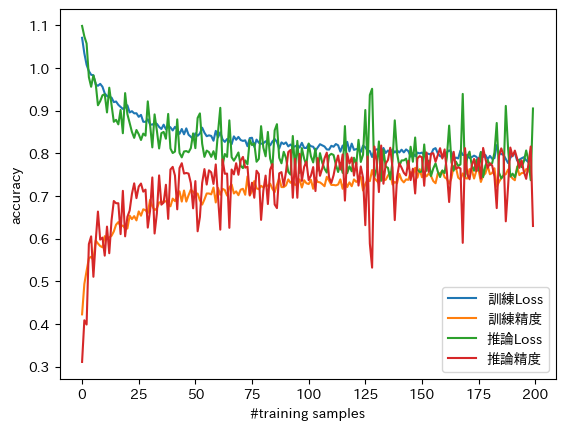

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

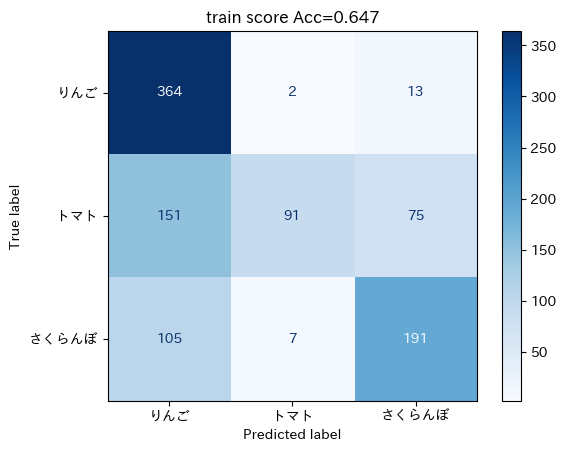

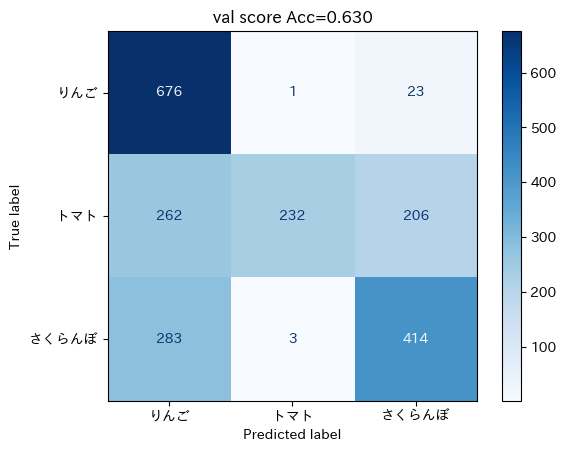

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

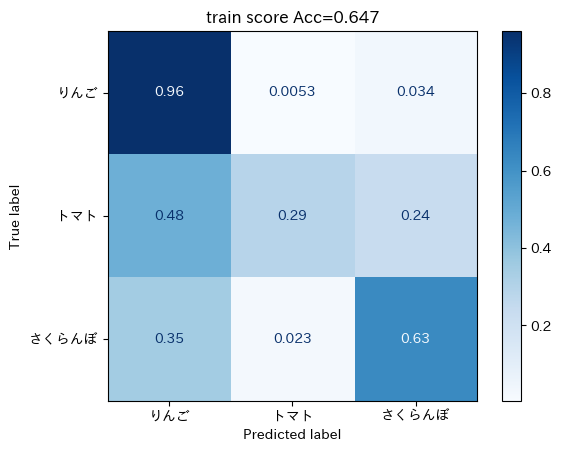

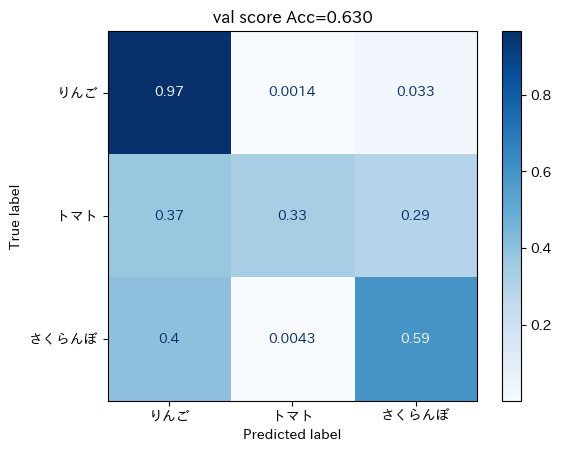

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()